# Multi-dimensional deconvolution with mini-batch stochastic gradient algorithms

In this notebook, we revisit the cost function MDD problem as a finite-sum cost function and we leverage this to solve it by means of minibatch stochastic gradient algorithms implemented in Pytorch.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from math import sqrt
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

from stochmdd import MDDminibatch, MDDpage

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G, Gwav = np.zeros((ns,nr,nt)), np.zeros((ns,nr,nt))
for iy, y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G, Gwav = G*tap, Gwav*tap

In [3]:
# Add negative part to operator and model
m = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)

# Create data
d = MDCop * m.ravel()
d = d.reshape(2*nt-1, ns)

# Convert to torch tensors
d = torch.from_numpy(d)
m = torch.from_numpy(m)
Gwav_fft = torch.from_numpy(Gwav_fft)

Dot test passed, v^T(Opu)=-5562.436318 - u^T(Op^Tv)=-5562.436318


In [5]:
#nepochs = 30
#batch_size = 11

nepochs = 30
batch_size = 21

lossdict = {}
avgdict = {}
enormdict = {}
mdict = {}

# Normal solvers

## SGD

In [6]:
model, dmod, lossdict['SGD'], avgdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              **dict(lr=1., weight_decay=0))
                 
mdict["SGD"] = model.detach().numpy()

epoch:  10, loss : 9.9912e-03, loss avg : 1.1196e-02
epoch:  20, loss : 5.3813e-03, loss avg : 4.7831e-03
epoch:  30, loss : 2.8333e-03, loss avg : 2.9427e-03


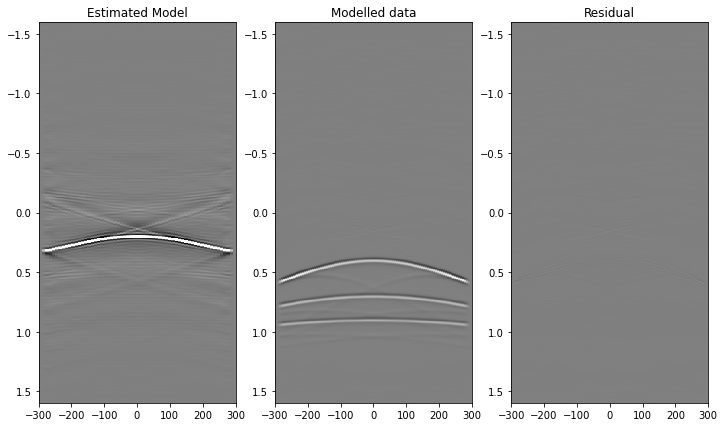

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## SGD with momentum

In [8]:
model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], enormdict['SGDMom'], _ = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              **dict(lr=0.3 if batch_size==11 else 0.5, momentum=0.9, nesterov=True))
                 
mdict["SGDMom"] = model.detach().numpy()

epoch:  10, loss : 1.9806e-03, loss avg : 2.2491e-03
epoch:  20, loss : 8.6439e-04, loss avg : 8.0779e-04
epoch:  30, loss : 4.7284e-04, loss avg : 4.9295e-04


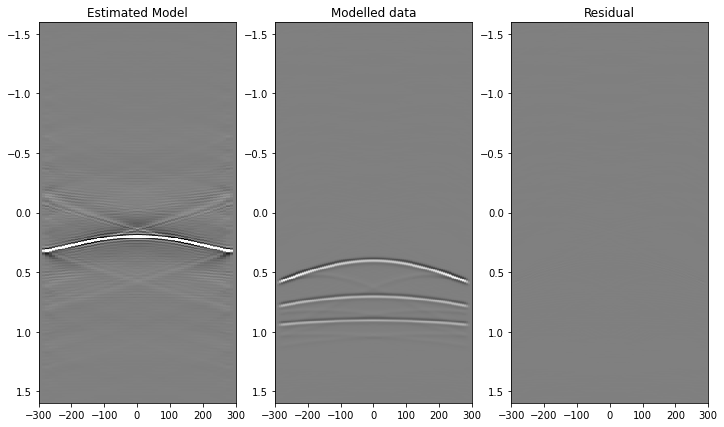

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## Adagrad

In [10]:
model, dmod, lossdict['Adagrad'], avgdict['Adagrad'], enormdict['Adagrad'], _ = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.Adagrad, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              **dict(lr=0.01, eps=1e-6))
                 
mdict["Adagrad"] = model.detach().numpy()

epoch:  10, loss : 1.0069e-01, loss avg : 1.0839e-01
epoch:  20, loss : 6.2457e-02, loss avg : 5.3635e-02
epoch:  30, loss : 3.3912e-02, loss avg : 3.2974e-02


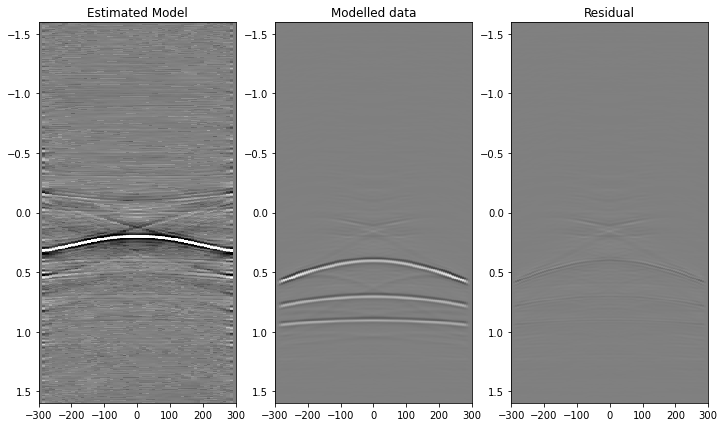

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## Adam

In [12]:
model, dmod, lossdict['Adam'], avgdict['Adam'], enormdict['Adam'], _ = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.Adam, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              **dict(lr=0.003 if batch_size==11 else 0.001, eps=1e-6))
                 
mdict["Adam"] = model.detach().numpy()

epoch:  10, loss : 2.6306e-01, loss avg : 2.7904e-01
epoch:  20, loss : 1.5192e-01, loss avg : 1.3581e-01
epoch:  30, loss : 7.7528e-02, loss avg : 7.6130e-02


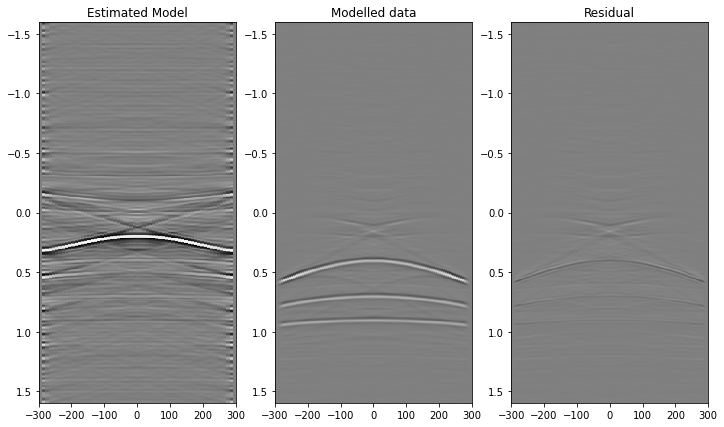

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## Page

In [14]:
no_of_batches=np.ceil(Gwav2.shape[0]/batch_size)

batches = np.diff(np.hstack((np.arange(0, ns, batch_size), np.array([ns, ]))))
no_of_batches_discounted = no_of_batches - 1 + batches[-1]/batches[0]
print(batches, no_of_batches, no_of_batches_discounted)

enormavgdict = {}
nepochs_eff = {}

[21 21 21 21 17] 5.0 4.809523809523809


In [15]:
batch_size1=int(sqrt(batch_size))
print(batch_size1/(batch_size+batch_size1))

model, dmod, lossdict['Page'], avgdict['Page'], enormdict['Page'], enormavgdict['Page'], gradcount, gradcount1 = \
                 MDDpage(nt, nr, dt, dr, Gwav_fft, d,
                         nepochs, batch_size, batch_size1, lr=.1, mtrue=m, seed=0, removelast=True)
                 
mdict["Page"] = model.detach().numpy()
nepochs_eff["Page"] = (gradcount + gradcount1 * batch_size1 / batch_size) / no_of_batches

0.16
epoch:  10, loss : 1.9012e-01, loss avg : 1.7461e-01
epoch:  20, loss : 7.7191e-02, loss avg : 7.2549e-02
epoch:  30, loss : 4.1096e-02, loss avg : 4.5176e-02
grad: 24, grad1 : 126


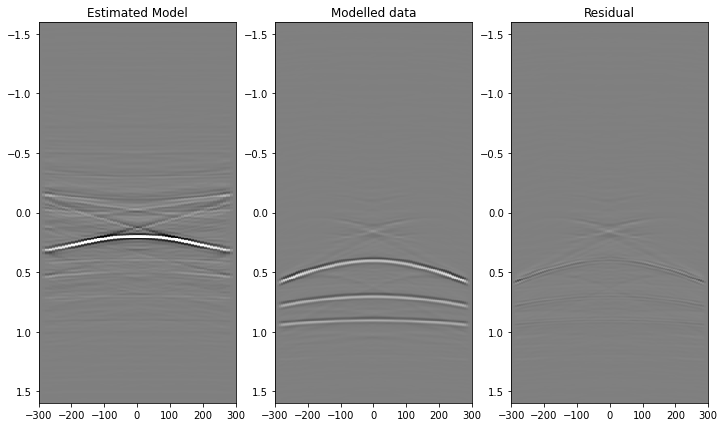

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## Comparison

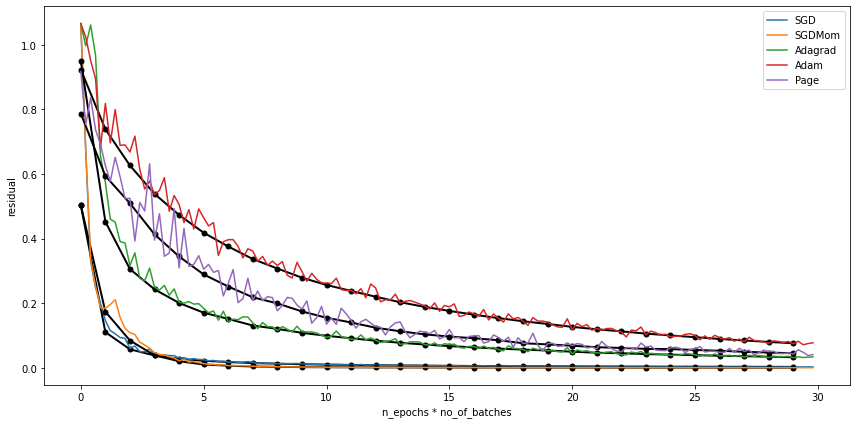

In [17]:
fig = plt.figure(figsize= (12,6))
for loss, avg in zip(lossdict.keys(), avgdict.keys()):
    plt.plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, avgdict[avg], '.-k', ms=10,
             linewidth = 2)
    plt.plot(np.arange(len(lossdict[loss]))/no_of_batches , lossdict[loss], label = loss)
    plt.xlabel('n_epochs * no_of_batches')
    plt.ylabel('residual')
    plt.legend()
    plt.tight_layout()

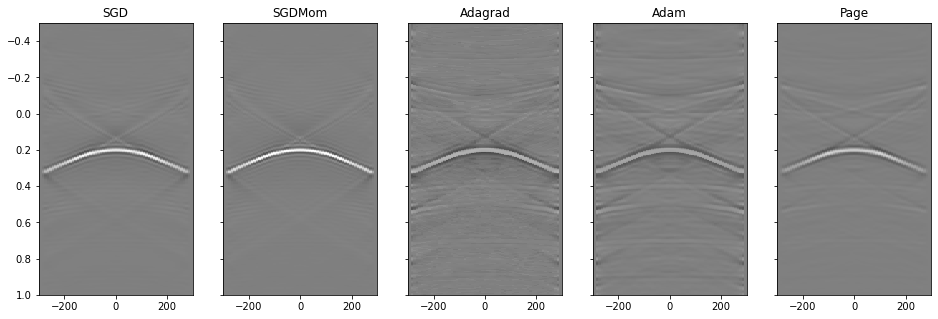

In [18]:
fig, axs = plt.subplots(1, len(mdict), sharey=True, figsize=(16, 5))
for iloss, loss in enumerate(mdict.keys()):
    axs[iloss].imshow(mdict[loss], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-mdict['SGD'].max(), vmax=mdict['SGD'].max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
    axs[iloss].axis('tight')
    axs[iloss].set_title(loss)
axs[-1].set_ylim(1., -0.5);

# Solvers with lr_schedulers

In [19]:
sch_lossdict = {}
sch_avgdict = {}
sch_enormdict = {}

## SGD with exponential LR

In [20]:
model, dmod, sch_lossdict['SGD_LRexp'], sch_avgdict['SGD_LRexp'], sch_enormdict['SGD_LRexp'], lr = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=.5, weight_decay=0))
                 
mdict["SGD_LRexp"] = model.detach().numpy()

epoch:  10, loss : 2.8499e-02, loss avg : 3.2238e-02
epoch:  20, loss : 2.1660e-02, loss avg : 1.7901e-02
epoch:  30, loss : 1.3189e-02, loss avg : 1.3648e-02


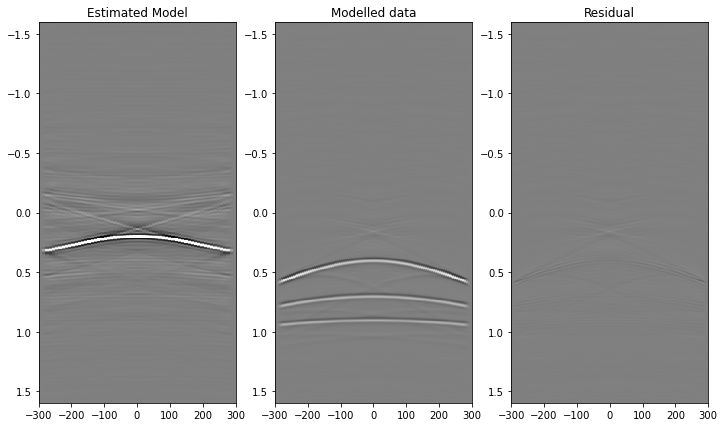

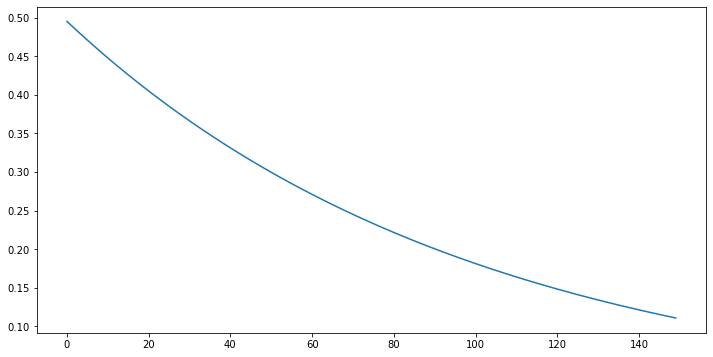

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual')

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

## SGD with momentum with exponential LR

In [22]:
model, dmod, sch_lossdict['SGDMom_LRexp'], sch_avgdict['SGDMom_LRexp'], sch_enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                              kwargs_sched=dict(gamma=0.99, last_epoch=-1, verbose=False),
                              **dict(lr=.5, momentum=0.9, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

epoch:  10, loss : 2.4503e-03, loss avg : 2.6997e-03
epoch:  20, loss : 1.4153e-03, loss avg : 1.3065e-03
epoch:  30, loss : 9.7352e-04, loss avg : 1.0132e-03


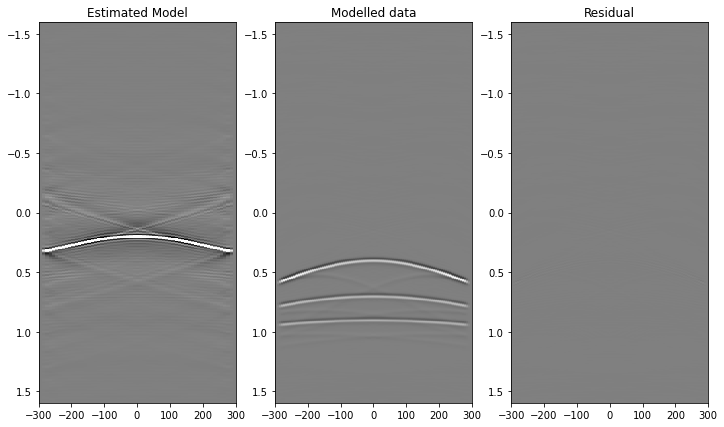

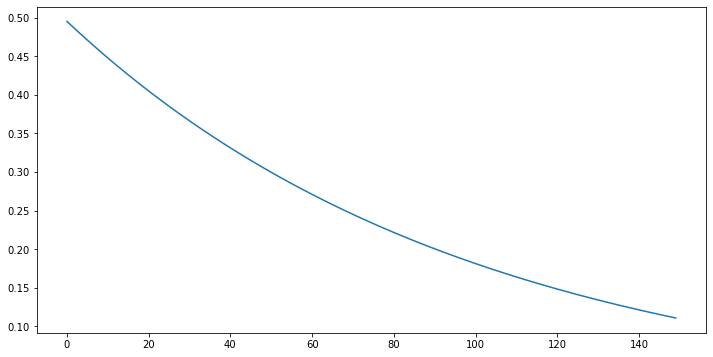

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual')

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

## SGD with cyclic LR

In [24]:
model, dmod, sch_lossdict['SGD_LROcyc'], sch_avgdict['SGD_LROcyc'], sch_enormdict['SGD_LROcyc'], lr = \
                 MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, 
                              nepochs, batch_size, mtrue=m, seed=0,
                              scheduler=torch.optim.lr_scheduler.OneCycleLR, 
                              kwargs_sched=dict(max_lr=1., epochs=nepochs, steps_per_epoch=int(no_of_batches), 
                                                cycle_momentum=False),
                              **dict(lr=.5))
                 
mdict["SGDMom_LRexp"] = model.detach().numpy()

epoch:  10, loss : 2.0045e-02, loss avg : 2.3888e-02
epoch:  20, loss : 8.4164e-03, loss avg : 7.2491e-03
epoch:  30, loss : 5.6804e-03, loss avg : 5.9526e-03


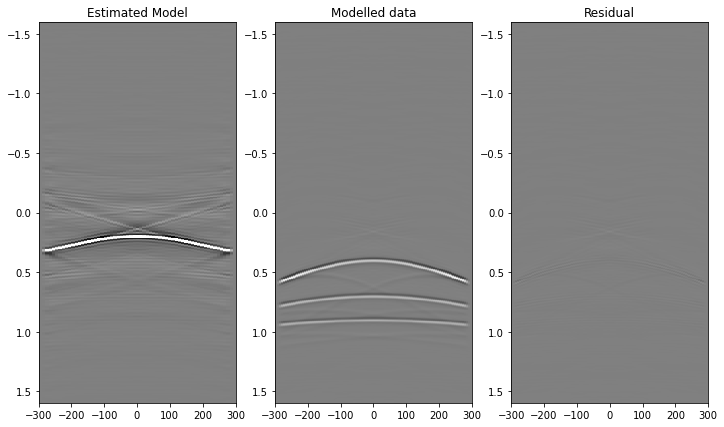

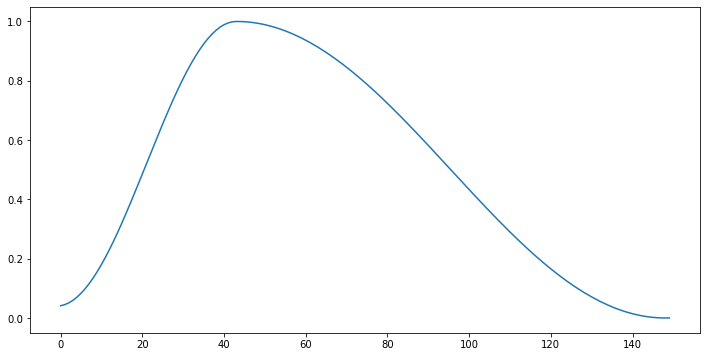

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual')

fig = plt.figure(figsize= (12,6))
plt.plot(lr);

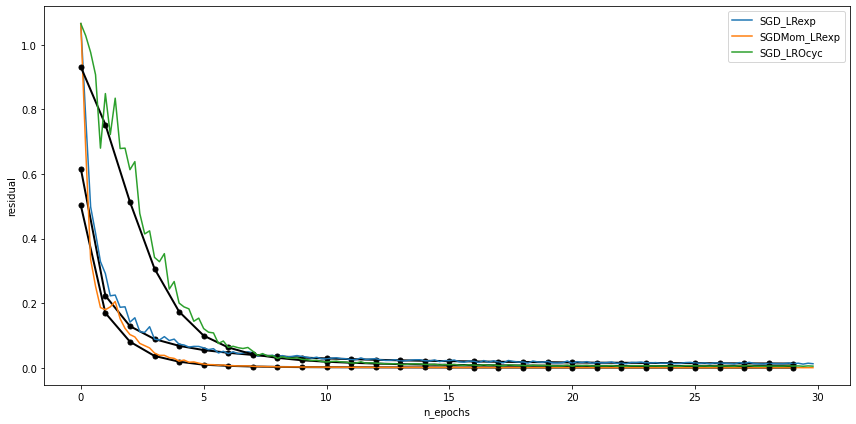

In [26]:
no_of_batches=np.ceil(Gwav2.shape[0]/batch_size)
fig = plt.figure(figsize= (12,6))
for loss, avg in zip(sch_lossdict.keys(), sch_avgdict.keys()):
    plt.plot((np.arange(0, no_of_batches*nepochs, no_of_batches))/no_of_batches, sch_avgdict[avg], '.-k', ms=10,
           linewidth = 2)
    plt.plot(np.arange(len(sch_lossdict[loss]))/no_of_batches , sch_lossdict[loss], label = loss)
    plt.xlabel('n_epochs')
    plt.ylabel('residual')
    plt.legend()
    plt.tight_layout()

## Final comparison

In [40]:
# Load standard time-domain MDD results
f = np.load('../MDD_basic_norms.npz') 

lsqr_minv = f['minv']
lsqr_cost = f['cost'] * Gwav2.shape[0]
lsqr_enorm = f['enorm']

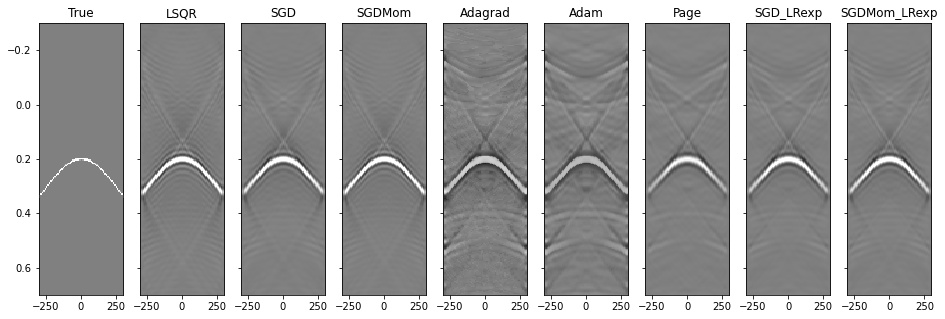

In [48]:
fig, axs = plt.subplots(1, len(mdict)+2, sharey=True, figsize=(16, 5))
axs[0].imshow(m, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2, vmax=0.2,
              extent=(x.min(),x.max(),t2.max(),t2.min()))
axs[0].axis('tight')
axs[0].set_title('True')
axs[1].imshow(lsqr_minv, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2, vmax=0.2,
              extent=(x.min(),x.max(),t2.max(),t2.min()))
axs[1].axis('tight')
axs[1].set_title('LSQR')
for iloss, loss in enumerate(mdict.keys()):
    axs[iloss+2].imshow(mdict[loss], aspect='auto', interpolation='nearest', cmap='gray',
                      vmin=-0.2, vmax=0.2,
                      extent=(x.min(),x.max(),t2.max(),t2.min()))
    axs[iloss+2].axis('tight')
    axs[iloss+2].set_title(loss)
axs[-1].set_ylim(0.7, -0.3);

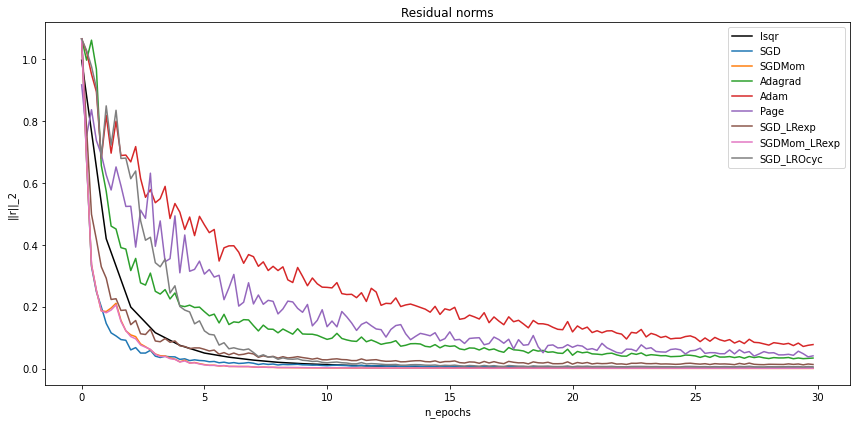

In [53]:
fig = plt.figure(figsize= (12,6))
plt.plot(lsqr_cost[:nepochs], 'k', label='lsqr')
for loss in lossdict.keys():
    plt.plot(np.arange(len(lossdict[loss]))/no_of_batches, lossdict[loss], label = str(loss).split()[0])
for losssch in sch_lossdict.keys():
    plt.plot(np.arange(len(sch_lossdict[losssch]))/no_of_batches, sch_lossdict[losssch],
           label = str(losssch).split()[0],linewidth = 1.5)
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms')
plt.legend()
plt.tight_layout()

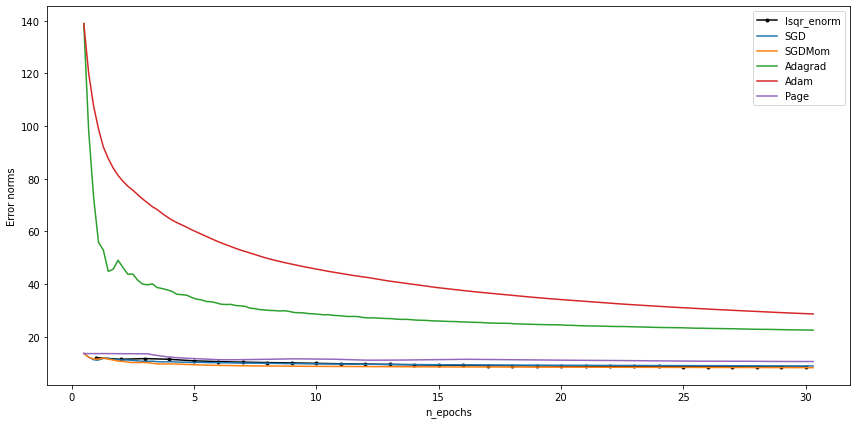

In [51]:
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs)+1, lsqr_enorm[:nepochs], '.-k', label = "lsqr_enorm")
for enorm in enormdict.keys():
    plt.plot(np.arange(len(enormdict[enorm]))/no_of_batches + 0.5, enormdict[enorm], label=enorm)
plt.ylabel('||e||_2')
plt.xlabel('n_epochs')
plt.title('Error norms')
plt.legend()
plt.tight_layout()

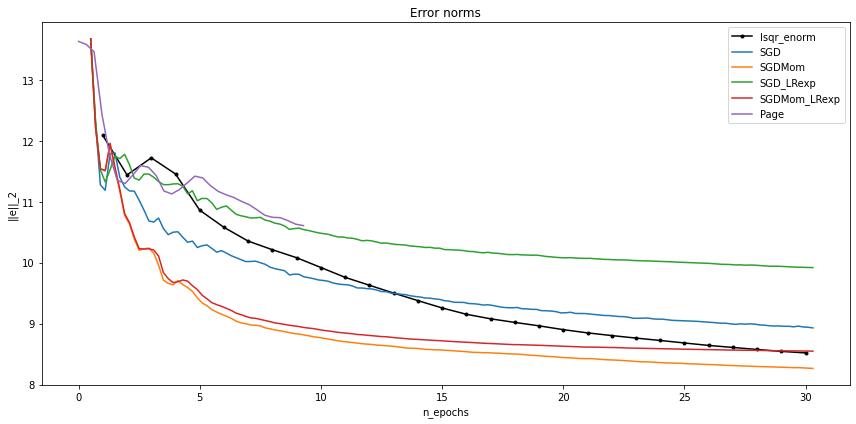

In [55]:
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs)+1, lsqr_enorm[:nepochs], '.-k', label = "lsqr_enorm")
for enorm in ['SGD', 'SGDMom']:
    plt.plot(np.arange(len(enormdict[enorm]))/no_of_batches + 0.5, enormdict[enorm], label=enorm)
for enorm in ['SGD_LRexp', 'SGDMom_LRexp']:
    plt.plot(np.arange(len(sch_enormdict[enorm]))/no_of_batches + 0.5, sch_enormdict[enorm], label=enorm)
for enorm in ['Page',]:
    plt.plot(np.arange(len(enormavgdict[enorm])) * nepochs_eff[enorm] / nepochs, enormavgdict[enorm], label=enorm)
plt.ylabel('||e||_2')
plt.xlabel('n_epochs')
plt.title('Error norms')
plt.legend()
plt.tight_layout()